<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/NINAnor/urban-treeDetection"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" style="filter: invert(100%)"/> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://drive.google.com/drive/folders/1mEQBfa-tVViVWFt27XzUP4Wr19u1iuZm"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# Urban Tree Detection | Extrapolating Ecosystem Service Values

**Author:** Willeke A'Campo

**Description:** Script to clean the output i-Tree Eco dataset and extrapolate the Ecosystem Service Values to all trees in the municipality. The regression is trained on the in situ tree dataset from the municipality or if not availabe on Oslo's tree in situ tree data. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import geopandas as gpd
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# import py-packages
import os
import logging

# import local packages
from src.config.config import load_catalog, load_parameters
from src.config import logger

# configure logger
logger.setup_logging()
logger = logging.getLogger(__name__)

# configure seaborn plot
sns.set_theme(
    context="notebook",  # paper, notebook, talk, and poster
    style="darkgrid",  # darkgrid, whitegrid, dark, white, and ticks
    palette="dark",  # deep, muted, bright, pastel, dark, and colorblind
    font="sans-serif",  # font family: serif, sans-serif, cursive, fantasy, and monospace
    font_scale=1,  # 1 = default font size (12pt)
    color_codes=True,  # False = don't color code from current palette
    rc=None,  # dict for additional settings (e.g. axes.labelsize=15)
)

2023-10-22 20:52:30 root [INFO]: Logging configuration file found and loaded.


In [4]:
# Load data and parameters
catalog = load_catalog()
parameters = load_parameters()
municipality = parameters["municipality"]
print(municipality)

# input
reference_excel = catalog["reference_municipality"]["filepath"]
reference_sheet = catalog["reference_municipality"]["sheet_names"][1]
target_excel = catalog["target_municipality"]["filepath"]
target_sheet = catalog["target_municipality"]["sheet_names"][1]
print(reference_sheet)
print(target_sheet)

# output
output_extrapolation = catalog["extrapolated_values"]["filepath"]
print(output_extrapolation)

bodo
reference_data
target_data
C:/Data/offline_data/trekroner/data/bodo/itree-support-tools/processed/bodo_extrapolated_values.csv


### Import Reference Data Bodo

In [5]:
# Load reference data 
workbook = pd.ExcelFile(reference_excel)
sheet_names = workbook.sheet_names
print(f"workbook sheet names: {sheet_names}")

df_raw = pd.read_excel(reference_excel, sheet_name=reference_sheet)

# import metadata
df_metadata = pd.read_excel(reference_excel, sheet_name="metadata")
df_metadata = df_metadata[["reference_data_names", "python_colnames", "dtype"]]

# import species list
df_species = pd.read_excel(reference_excel, sheet_name="unique_species")
species_bins = df_species["species"].tolist()

print("Raw data information: Oslo Reference Data")
display(df_raw.head())
print("Rows in dataframe: ", len(df_raw))
print(f"\nunique species: {species_bins}")
print("\nMetadata information: ")
display(df_metadata.head())

workbook sheet names: ['reference_data', 'unique_species', 'metadata']
Raw data information: Oslo Reference Data


,OBJECTID,crown_id,tree_id,scientific_name,norwegian_name,taxon_genus,common_name,species_origin,crown_area,tree_height_laser,...,nb_name,geo_relation,wgs84_lon,wgs84_lat,replacement_value_kr,carbon_storage,carbon_seq,runoff_m3,total_pollution,totben_cap
0,1,b_180401_1,itree_3006,NaN,Svensk asal,NaN,Swedish Whitebeam,feltregistrering,108.970001,9.17,...,Molo,Case 1,14.387265,67.285173,15518.61,527.4,8.4,0.1,56.6,55.20
1,2,b_180401_2,itree_4754,Betula,Bjørk,Betula,Birch spp,feltregistrering,9.610000,12.65,...,Molo,Case 2,14.404934,67.283990,499.65,2.3,1.4,0.0,13.7,12.22
2,3,b_180401_3,itree_4762,Betula,Bjørk,Betula,Birch spp,feltregistrering,20.430000,12.65,...,Molo,Case 2,14.404996,67.283956,1391.42,8.2,2.9,0.0,25.0,22.79
3,4,b_180401_4,itree_4782,Sorbus,Rogn,Sorbus,Mountain Ash spp,feltregistrering,20.260000,12.65,...,Molo,Case 2,14.404970,67.284038,13781.83,269.7,19.8,0.1,34.5,61.36
4,5,b_180401_5,itree_4755,Populus tremula,Osp,Populus,European aspen,feltregistrering,15.370000,12.65,...,Molo,Case 2,14.404952,67.284011,800.24,5.9,2.7,0.0,19.5,18.72


Rows in dataframe:  6155

unique species: ['Alm', 'Alpeasal', 'Amerikahagtorn', 'Anna Art', 'Ask', 'Balsampoppel', 'Bjørk', 'Blodbøk', 'Dunpil', 'Eple', 'Furu', 'Gran', 'Gråor', 'Gråselje', 'Gullregn', 'Hagtorn', 'Hegg', 'Hengebjørk', 'Hestekastanje', 'Hvitpil', 'Istervier', 'Katsuratre', 'Kurvpil', 'Lerk', 'Morell', 'Neverhegg', 'Ornäsbjørk', 'Osp', 'Platanlønn', 'Prydeple', 'Rogn', 'Rognasal', 'Rød spisslønn', 'Rødhyll', 'Sargentkirsebær', 'Selje', 'Sitkagran', 'Spisslønn', 'Svensk asal', 'Syrin', 'Sølvasal', 'Sølvpil', 'Tartarlønn', 'Ukjent', 'Ullungrogn', 'Valnøtt']

Metadata information: 


,reference_data_names,python_colnames,dtype
0,tree_id,tree_id,int
1,crown_id,crown_id,int
2,norwegian_name,species,object
3,crown_area,crown_area,float64
4,height_total_tree,tree_height,float64


### Clean dataset
- remove rows with missing values
- remove rows with negative values (not done)

In [6]:
# drop row with missing values in column "crown_area", "height_total_tree" or "pollution_zone"
df = df_raw.dropna(subset=["crown_area", 
                           "height_total_tree",
                           "pollution_zone", 
                           "carbon_storage",
                            "carbon_seq",
                            "runoff_m3",
                            "total_pollution",
                            "totben_cap"])
print("Length of Complete DF:", len(df_raw))
print ("Length of Cleaned DF:", len(df))
display(df.head())
print(df.shape)



Length of Complete DF: 6155
Length of Cleaned DF: 6102


,OBJECTID,crown_id,tree_id,scientific_name,norwegian_name,taxon_genus,common_name,species_origin,crown_area,tree_height_laser,...,nb_name,geo_relation,wgs84_lon,wgs84_lat,replacement_value_kr,carbon_storage,carbon_seq,runoff_m3,total_pollution,totben_cap
0,1,b_180401_1,itree_3006,NaN,Svensk asal,NaN,Swedish Whitebeam,feltregistrering,108.970001,9.17,...,Molo,Case 1,14.387265,67.285173,15518.61,527.4,8.4,0.1,56.6,55.20
1,2,b_180401_2,itree_4754,Betula,Bjørk,Betula,Birch spp,feltregistrering,9.610000,12.65,...,Molo,Case 2,14.404934,67.283990,499.65,2.3,1.4,0.0,13.7,12.22
2,3,b_180401_3,itree_4762,Betula,Bjørk,Betula,Birch spp,feltregistrering,20.430000,12.65,...,Molo,Case 2,14.404996,67.283956,1391.42,8.2,2.9,0.0,25.0,22.79
3,4,b_180401_4,itree_4782,Sorbus,Rogn,Sorbus,Mountain Ash spp,feltregistrering,20.260000,12.65,...,Molo,Case 2,14.404970,67.284038,13781.83,269.7,19.8,0.1,34.5,61.36
4,5,b_180401_5,itree_4755,Populus tremula,Osp,Populus,European aspen,feltregistrering,15.370000,12.65,...,Molo,Case 2,14.404952,67.284011,800.24,5.9,2.7,0.0,19.5,18.72


(6102, 27)


- rename columns 
- trim column names
- set dtype of columns 

In [7]:
# trim and rename columns using metadata
col_name_mapping = dict(
    zip(df_metadata["reference_data_names"], df_metadata["python_colnames"])
)
df.columns = df.columns.str.strip()
df.rename(columns=col_name_mapping, inplace=True)
df.columns = df.columns.str.strip()

# update column dtypes using metadata
dtype_mapping = dict(zip(df_metadata["python_colnames"], df_metadata["dtype"]))

# remove all values from dtype_mapping if they are not in df.columns
dtype_mapping = {
    key: dtype_mapping[key] for key in dtype_mapping.keys() if key in df.columns
}

# convert column dtypes using dtype_mapping
for key in dtype_mapping.keys():
    # print(f"column: {key}\t current dtype: {df[key].dtypes} \ttarget dtype: {dtype_mapping[key]}")
    # if the current dtype is not the target dtype, convert the column
    if df[key].dtypes != dtype_mapping[key]:
        try:
            if dtype_mapping[key] == "int":
                df[key] = df[key].astype(int)
                print(f"column: {key} converted to {df[key].dtypes}")
            elif dtype_mapping[key] == "float64":
                df[key] = df[key].astype(float)
                print(f"column: {key} converted to {df[key].dtypes}")
            elif dtype_mapping[key] == "object":
                df.astype({key: "object"}).dtypes
                print(f"column: {key} converted to {df[key].dtypes}")
        except ValueError:
            print(
                f"column: {key} ({df[key].dtypes}) could not be converted to {dtype_mapping[key]}"
            )
            pass
    else:
        print(
            f"column: {key} ({df[key].dtypes}) has already dtype: {dtype_mapping[key]}"
        )
        pass

column: tree_id (object) could not be converted to int
column: crown_id (object) could not be converted to int
column: species (object) has already dtype: object
column: crown_area (float64) has already dtype: float64
column: tree_height (float64) has already dtype: float64
column: dbh (float64) has already dtype: float64
column: pollution_zone converted to int32
column: lon_x (float64) has already dtype: float64
column: lat_y (float64) has already dtype: float64
column: carbon_storage (float64) has already dtype: float64
column: carbon_seq (float64) has already dtype: float64
column: runoff (float64) has already dtype: float64
column: total_pollution (float64) has already dtype: float64
column: totben_cap (float64) has already dtype: float64


C:\Users\willeke.acampo\AppData\Local\Temp\ipykernel_5824\3526722575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=col_name_mapping, inplace=True)
C:\Users\willeke.acampo\AppData\Local\Temp\ipykernel_5824\3526722575.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = df[key].astype(int)


### Import and clean Target Data Bodo

In [8]:
# import target dataset
df_target_raw = pd.read_excel(target_excel, sheet_name=target_sheet)
display(df_target_raw.head())

,OBJECTID,crown_id,tree_id,crown_area,height_total_tree,height_origin,dbh,pollution_zone,wgs84_lon,wgs84_lat
0,6156,b_180401_6156,NaN,13.000000,2.78,laserdata,NaN,1,14.405960,67.290894
1,6157,b_180401_6157,NaN,46.240002,2.70,laserdata,NaN,1,14.404625,67.289885
2,6158,b_180401_6158,NaN,16.500000,3.38,laserdata,NaN,1,14.406264,67.289688
3,6159,b_180401_6159,NaN,120.470001,3.06,laserdata,NaN,1,14.404566,67.289721
4,6160,b_180401_6160,NaN,49.990002,2.85,laserdata,NaN,1,14.404638,67.289630


In [9]:
df_target= df_target_raw.dropna(subset=["crown_area", "height_total_tree", "pollution_zone"])
print("Length of Complete DF:", len(df_target_raw))
print ("Length of Cleaned DF:", len(df_target))

Length of Complete DF: 97583
Length of Cleaned DF: 97583


In [10]:
col_list = df.columns
print(col_list)

# drop columns that are in the target dataset
col_list = [col for col in col_list if col not in df_target.columns]
print(col_list)

# add col list as columns to target_df
df_target = pd.concat([df_target, pd.DataFrame(columns=col_list)], axis=1)
df_target["tree_height"] = df_target["height_total_tree"]
df_target["lon_x"] = df_target["wgs84_lon"]
df_target["lat_y"] = df_target["wgs84_lat"]
display(df_target.head())

# drop row with missing values in column "crown_area", "height_total_tree" or "pollution_zone"
df_target = df_target.dropna(subset=["crown_area", "tree_height", "pollution_zone"])
print("Length of Complete DF:", len(df_target_raw))
print ("Length of Cleaned DF:", len(df_target))

Index(['OBJECTID', 'crown_id', 'tree_id', 'scientific_name', 'species',
       'taxon_genus', 'common_name', 'species_origin', 'crown_area',
       'tree_height_laser', 'height_insitu', 'tree_height', 'height_origin',
       'dbh', 'dbh_origin', 'pollution_zone', 'nb_code', 'nb_name',
       'geo_relation', 'lon_x', 'lat_y', 'replacement_value_kr',
       'carbon_storage', 'carbon_seq', 'runoff', 'total_pollution',
       'totben_cap'],
      dtype='object')
['scientific_name', 'species', 'taxon_genus', 'common_name', 'species_origin', 'tree_height_laser', 'height_insitu', 'tree_height', 'dbh_origin', 'nb_code', 'nb_name', 'geo_relation', 'lon_x', 'lat_y', 'replacement_value_kr', 'carbon_storage', 'carbon_seq', 'runoff', 'total_pollution', 'totben_cap']


,OBJECTID,crown_id,tree_id,crown_area,height_total_tree,height_origin,dbh,pollution_zone,wgs84_lon,wgs84_lat,...,nb_name,geo_relation,lon_x,lat_y,replacement_value_kr,carbon_storage,carbon_seq,runoff,total_pollution,totben_cap
0,6156,b_180401_6156,NaN,13.000000,2.78,laserdata,NaN,1,14.405960,67.290894,...,NaN,NaN,14.405960,67.290894,NaN,NaN,NaN,NaN,NaN,NaN
1,6157,b_180401_6157,NaN,46.240002,2.70,laserdata,NaN,1,14.404625,67.289885,...,NaN,NaN,14.404625,67.289885,NaN,NaN,NaN,NaN,NaN,NaN
2,6158,b_180401_6158,NaN,16.500000,3.38,laserdata,NaN,1,14.406264,67.289688,...,NaN,NaN,14.406264,67.289688,NaN,NaN,NaN,NaN,NaN,NaN
3,6159,b_180401_6159,NaN,120.470001,3.06,laserdata,NaN,1,14.404566,67.289721,...,NaN,NaN,14.404566,67.289721,NaN,NaN,NaN,NaN,NaN,NaN
4,6160,b_180401_6160,NaN,49.990002,2.85,laserdata,NaN,1,14.404638,67.289630,...,NaN,NaN,14.404638,67.289630,NaN,NaN,NaN,NaN,NaN,NaN


Length of Complete DF: 97583
Length of Cleaned DF: 97583


In [11]:
df_target.columns = df_target.columns.str.strip()

# remove all values from dtype_mapping if they are not in df.columns
dtype_mapping = {
    key: dtype_mapping[key] for key in dtype_mapping.keys() if key in df_target.columns
}

# convert column dtypes using dtype_mapping
for key in dtype_mapping.keys():
    # print(f"column: {key}\t current dtype: {df[key].dtypes} \ttarget dtype: {dtype_mapping[key]}")
    # if the current dtype is not the target dtype, convert the column
    if df_target[key].dtypes != dtype_mapping[key]:
        try:
            if dtype_mapping[key] == "int":
                df_target[key] = df_target[key].astype(int)
                print(f"column: {key} converted to {df_target[key].dtypes}")
            elif dtype_mapping[key] == "float64":
                df_target[key] = df_target[key].astype(float)
                print(f"column: {key} converted to {df_target[key].dtypes}")
            elif dtype_mapping[key] == "object":
                df_target.astype({key: "object"}).dtypes
                print(f"column: {key} converted to {df_target[key].dtypes}")
        except ValueError:
            print(
                f"column: {key} ({df_target[key].dtypes}) could not be converted to {dtype_mapping[key]}"
            )
            pass
    else:
        print(
            f"column: {key} ({df_target[key].dtypes}) has already dtype: {dtype_mapping[key]}"
        )
        pass

column: tree_id (object) could not be converted to int
column: crown_id (object) could not be converted to int
column: species (object) has already dtype: object
column: crown_area (float64) has already dtype: float64
column: tree_height (float64) has already dtype: float64
column: dbh (float64) has already dtype: float64
column: pollution_zone converted to int32
column: lon_x (float64) has already dtype: float64
column: lat_y (float64) has already dtype: float64
column: carbon_storage converted to float64
column: carbon_seq converted to float64
column: runoff converted to float64
column: total_pollution converted to float64
column: totben_cap converted to float64


### Correlation analysis

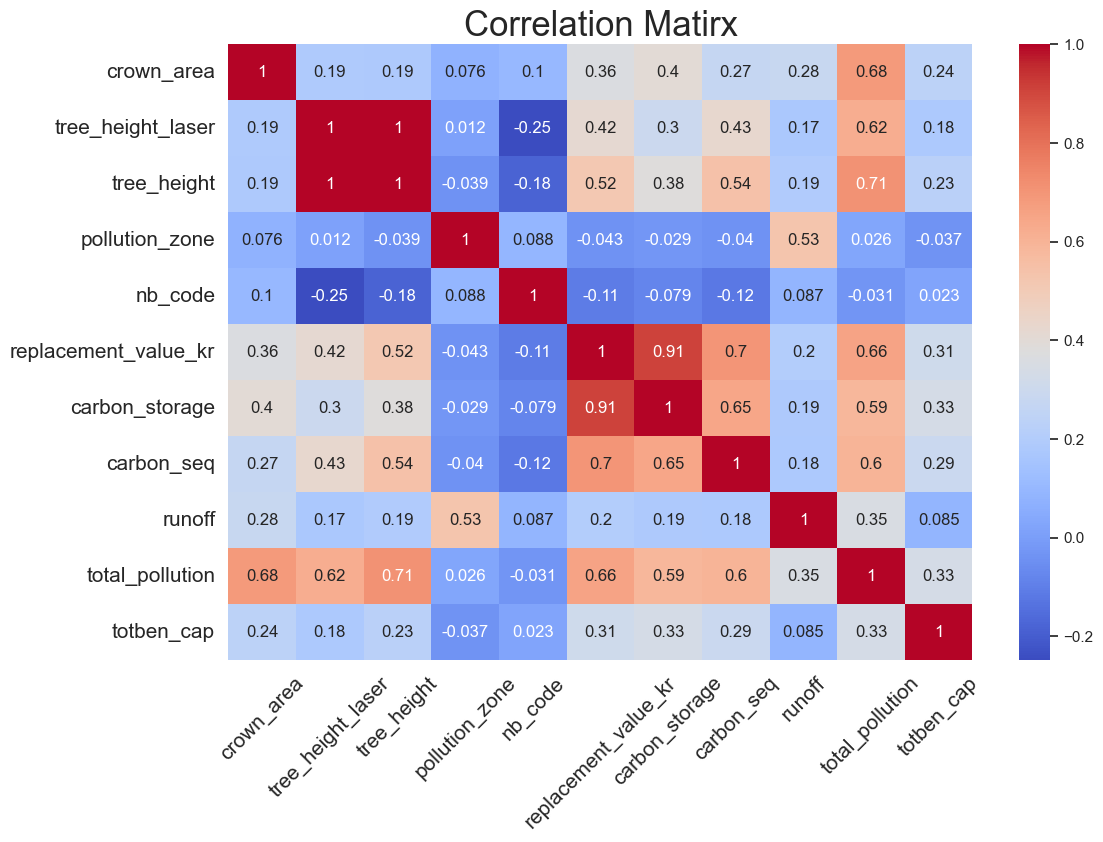

In [12]:
# drop columns with name 'id' and 'species'
df_corr = df.drop(
    ["OBJECTID", "tree_id", "crown_id", "dbh", "lon_x", "lat_y"], axis=1
)
correlation_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
ax.set_title("Correlation Matirx", fontweight="ultralight", fontsize=25)
plt.xticks(rotation=45, fontweight="ultralight", fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- select columns to keep for modelling
- round values for pred and response var to 3 decimals (ensure that X,Y columns are not rounded!)

In [13]:
# print(df.columns)
col_id = ["tree_id", "crown_id"]
col_coord = ["lon_x", "lat_y"]
predictors = ["tree_height", "crown_area", "pollution_zone", "species"]
response_vars = [
    "carbon_storage",
    "carbon_seq",
    "runoff",
    "total_pollution",
    "totben_cap",
]

col_to_keep = col_id + predictors + response_vars + col_coord
print(col_to_keep)
df = df[col_to_keep]

# round response and predictor values to 2 decimals
df[predictors + response_vars] = df[predictors + response_vars].round(2)
print("REFERENCE DATA:")
print(df.shape)
display(df.head())

df_target = df_target[col_to_keep]
df_target[predictors + response_vars] = df_target[predictors + response_vars].round(2)
print("TARGET DATA:")
print(df_target.shape)
display(df_target.head())

['tree_id', 'crown_id', 'tree_height', 'crown_area', 'pollution_zone', 'species', 'carbon_storage', 'carbon_seq', 'runoff', 'total_pollution', 'totben_cap', 'lon_x', 'lat_y']
REFERENCE DATA:
(6102, 13)


,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,totben_cap,lon_x,lat_y
0,itree_3006,b_180401_1,9.17,108.97,2,Svensk asal,527.4,8.4,0.1,56.6,55.20,14.387265,67.285173
1,itree_4754,b_180401_2,12.65,9.61,1,Bjørk,2.3,1.4,0.0,13.7,12.22,14.404934,67.283990
2,itree_4762,b_180401_3,12.65,20.43,1,Bjørk,8.2,2.9,0.0,25.0,22.79,14.404996,67.283956
3,itree_4782,b_180401_4,12.65,20.26,1,Rogn,269.7,19.8,0.1,34.5,61.36,14.404970,67.284038
4,itree_4755,b_180401_5,12.65,15.37,1,Osp,5.9,2.7,0.0,19.5,18.72,14.404952,67.284011


TARGET DATA:
(97583, 13)


,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,totben_cap,lon_x,lat_y
0,NaN,b_180401_6156,2.78,13.00,1,NaN,NaN,NaN,NaN,NaN,NaN,14.405960,67.290894
1,NaN,b_180401_6157,2.70,46.24,1,NaN,NaN,NaN,NaN,NaN,NaN,14.404625,67.289885
2,NaN,b_180401_6158,3.38,16.50,1,NaN,NaN,NaN,NaN,NaN,NaN,14.406264,67.289688
3,NaN,b_180401_6159,3.06,120.47,1,NaN,NaN,NaN,NaN,NaN,NaN,14.404566,67.289721
4,NaN,b_180401_6160,2.85,49.99,1,NaN,NaN,NaN,NaN,NaN,NaN,14.404638,67.289630


In [14]:
# create a histogram for species distribution
df_species = df.groupby("species").count()
df_species = df_species[["tree_id"]]
df_species.rename(columns={"tree_id": "count"}, inplace=True)
df_species.sort_values(by=["count"], inplace=True, ascending=False)
df_species.reset_index(inplace=True)

# probability distribution of species in percent
df_species["probability"] = df_species["count"] / df_species["count"].sum()
df_species["prob_percentage"] = round(df_species["probability"] * 100)
display(df_species.head())

df_species["probability"].sum()

,species,count,probability,prob_percentage
0,Bjørk,1263,0.206981,21.0
1,Svensk asal,925,0.151590,15.0
2,Rogn,684,0.112094,11.0
3,Selje,551,0.090298,9.0
4,Syrin,456,0.074730,7.0


1.0

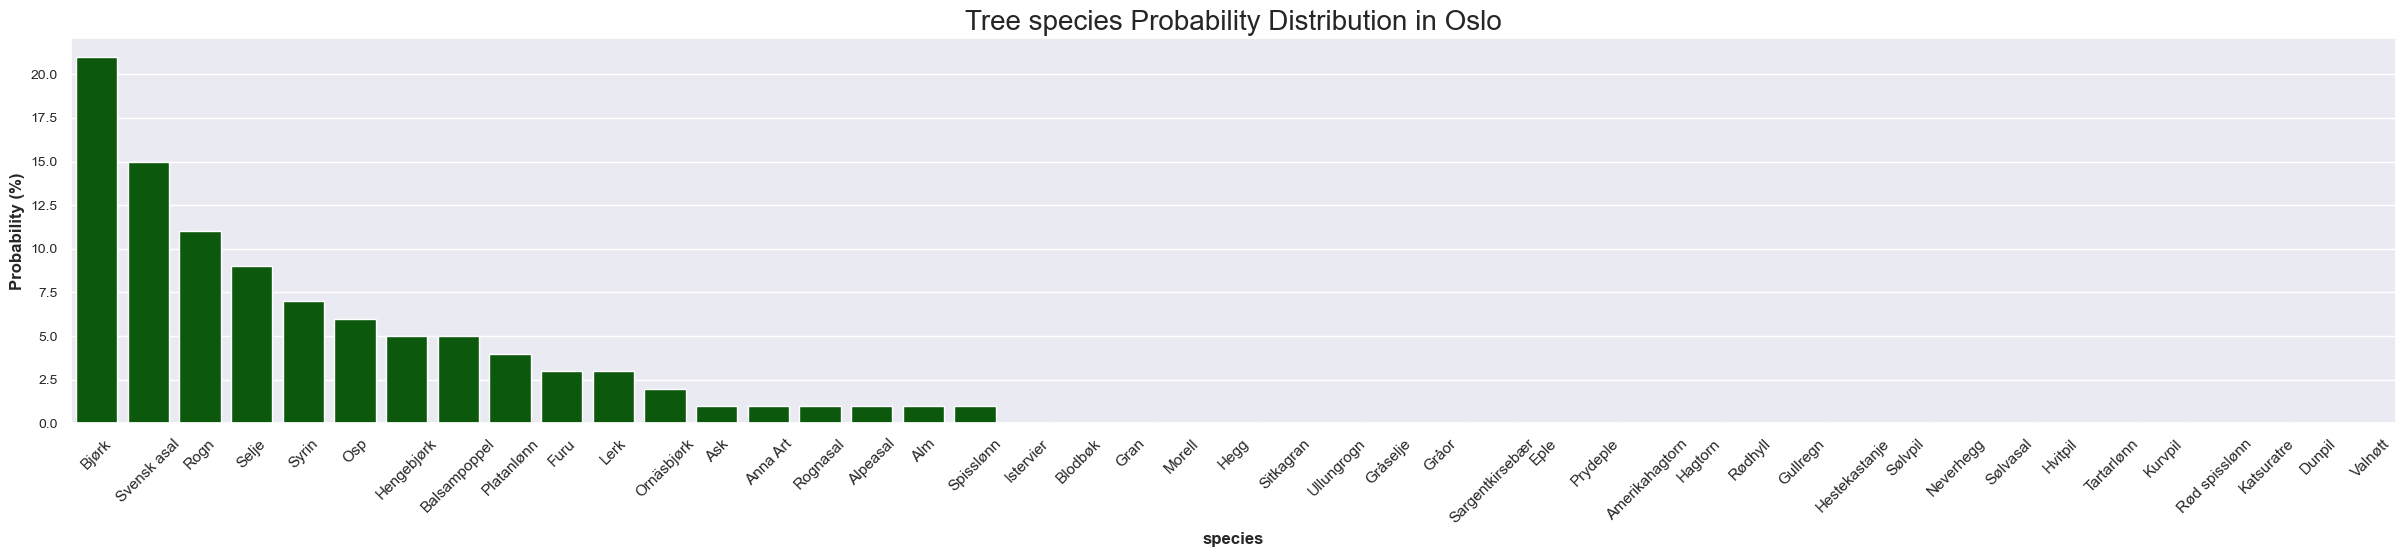

In [15]:
# plot histogram
fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(x="species", y="prob_percentage", data=df_species, ax=ax, color="darkgreen")
ax.set_title(
    "Tree species Probability Distribution in Oslo", fontweight="ultralight", fontsize=20
)
ax.set_xlabel("species", fontweight="bold")
ax.set_ylabel("Probability (%)", fontweight="bold")
plt.xticks(rotation=45, fontweight="ultralight")
plt.yticks(fontsize=10)
plt.show()

### Fill Target Dataset with species values using the probability distribution of Oslo 

In [16]:
# fil no data values in test_df['species'] by using the probability distribution of df['species']
df_target["species"] = df_target["species"].apply(
    lambda x: np.random.choice(df_species["species"], p=df_species["probability"])
    if pd.isnull(x)
    else x
)

# print the probability distribution of target_data['species']
target_data_species = df_target.groupby("species").count()
target_data_species = target_data_species[["tree_id"]]
target_data_species.rename(columns={"tree_id": "count"}, inplace=True)
target_data_species.sort_values(by=["count"], inplace=True, ascending=False)
target_data_species.reset_index(inplace=True)

,species,count,probability,prob_percentage
0,Bjørk,8,0.275862,28.0
1,Selje,3,0.103448,10.0
2,Svensk asal,3,0.103448,10.0
3,Syrin,2,0.068966,7.0
4,Lerk,2,0.068966,7.0


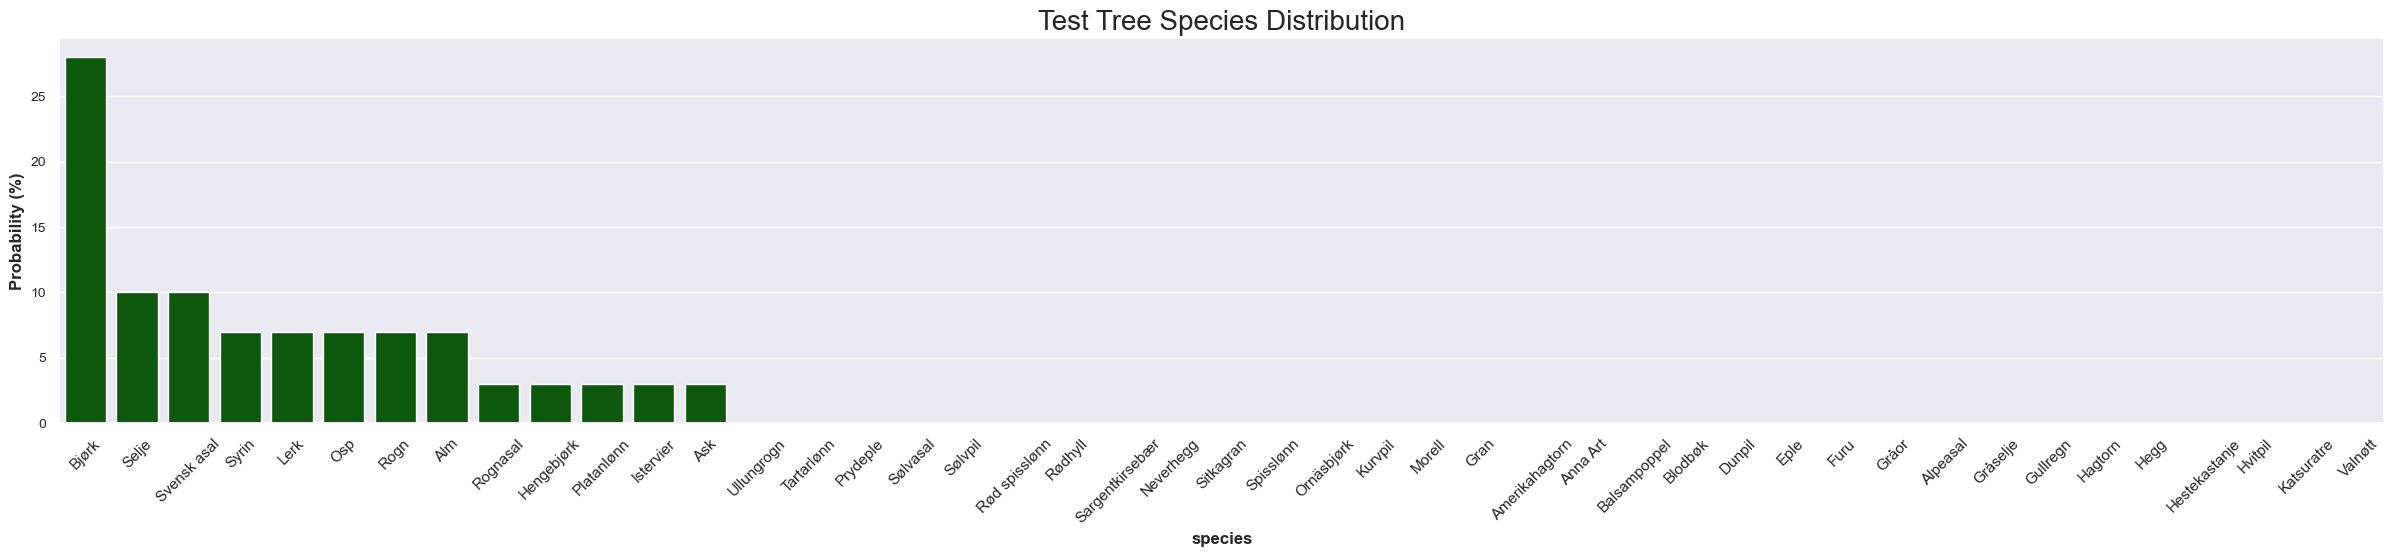

In [17]:
# probability distribution of species in percent
target_data_species["probability"] = (
    target_data_species["count"] / target_data_species["count"].sum()
)
target_data_species["prob_percentage"] = round(target_data_species["probability"] * 100)
display(target_data_species.head())

# plot histogram
fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(
    x="species", y="prob_percentage", data=target_data_species, ax=ax, color="darkgreen"
)
ax.set_title("Test Tree Species Distribution", fontweight="ultralight", fontsize=20)
ax.set_xlabel("species", fontweight="bold")
ax.set_ylabel("Probability (%)", fontweight="bold")
plt.xticks(rotation=45, fontweight="ultralight")
plt.yticks(fontsize=10)
plt.show()

In [18]:
display(df_target.head())

,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,totben_cap,lon_x,lat_y
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,NaN,NaN,NaN,NaN,NaN,14.405960,67.290894
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,NaN,NaN,NaN,NaN,NaN,14.404625,67.289885
2,NaN,b_180401_6158,3.38,16.50,1,Selje,NaN,NaN,NaN,NaN,NaN,14.406264,67.289688
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,NaN,NaN,NaN,NaN,NaN,14.404566,67.289721
4,NaN,b_180401_6160,2.85,49.99,1,Selje,NaN,NaN,NaN,NaN,NaN,14.404638,67.289630


### Non-weighted Regression with encoded species info

In [19]:
# One-hot encoding for species
df["species"] = df["species"].astype("category")

# encode species for regression
species_encoded = pd.get_dummies(df["species"], prefix="species")

# get species encoded column names
species_encoded_cols = list(species_encoded.columns)
# replace species_ wiht "" in column names
species_encoded_cols = [x.replace("species_", "") for x in species_encoded_cols]
species_encoded_cols = [x.lower() for x in species_encoded_cols]

# replace col names with formatted col names
species_encoded.columns = species_encoded_cols

df = pd.concat([df, species_encoded], axis=1)
print(species_encoded_cols)

['alm', 'alpeasal', 'amerikahagtorn', 'anna art', 'ask', 'balsampoppel', 'bjørk', 'blodbøk', 'dunpil', 'eple', 'furu', 'gran', 'gråor', 'gråselje', 'gullregn', 'hagtorn', 'hegg', 'hengebjørk', 'hestekastanje', 'hvitpil', 'istervier', 'katsuratre', 'kurvpil', 'lerk', 'morell', 'neverhegg', 'ornäsbjørk', 'osp', 'platanlønn', 'prydeple', 'rogn', 'rognasal', 'rød spisslønn', 'rødhyll', 'sargentkirsebær', 'selje', 'sitkagran', 'spisslønn', 'svensk asal', 'syrin', 'sølvasal', 'sølvpil', 'tartarlønn', 'ullungrogn', 'valnøtt']


In [20]:
target_species_encoded = pd.get_dummies(df_target["species"])
target_species_encoded_cols = list(target_species_encoded.columns)
target_species_encoded_cols = [x.lower() for x in target_species_encoded_cols]

# replace col names with formatted col names
target_species_encoded.columns = target_species_encoded_cols

df_target = pd.concat([df_target, target_species_encoded], axis=1)
display(df_target.head())

,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,...,selje,sitkagran,spisslønn,svensk asal,syrin,sølvasal,sølvpil,tartarlønn,ullungrogn,valnøtt
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,NaN,b_180401_6158,3.38,16.50,1,Selje,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
4,NaN,b_180401_6160,2.85,49.99,1,Selje,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [21]:
# ensure that df and df_target contain the same column names
same_columns = df.columns.equals(df_target.columns)
print(same_columns)
print(df.columns)
print(df_target.columns)

True
Index(['tree_id', 'crown_id', 'tree_height', 'crown_area', 'pollution_zone',
       'species', 'carbon_storage', 'carbon_seq', 'runoff', 'total_pollution',
       'totben_cap', 'lon_x', 'lat_y', 'alm', 'alpeasal', 'amerikahagtorn',
       'anna art', 'ask', 'balsampoppel', 'bjørk', 'blodbøk', 'dunpil', 'eple',
       'furu', 'gran', 'gråor', 'gråselje', 'gullregn', 'hagtorn', 'hegg',
       'hengebjørk', 'hestekastanje', 'hvitpil', 'istervier', 'katsuratre',
       'kurvpil', 'lerk', 'morell', 'neverhegg', 'ornäsbjørk', 'osp',
       'platanlønn', 'prydeple', 'rogn', 'rognasal', 'rød spisslønn',
       'rødhyll', 'sargentkirsebær', 'selje', 'sitkagran', 'spisslønn',
       'svensk asal', 'syrin', 'sølvasal', 'sølvpil', 'tartarlønn',
       'ullungrogn', 'valnøtt'],
      dtype='object')
Index(['tree_id', 'crown_id', 'tree_height', 'crown_area', 'pollution_zone',
       'species', 'carbon_storage', 'carbon_seq', 'runoff', 'total_pollution',
       'totben_cap', 'lon_x', 'lat_y', 'a

In [22]:
# Extract the features (X) and the target variable (y) from the DataFrame
predictors = ["tree_height", "crown_area", "pollution_zone"] + species_encoded_cols
response_vars = [
    "carbon_storage",
    "carbon_seq",
    "runoff",
    "total_pollution",
    "totben_cap",
]

for var in response_vars:
    y = df[var]

In [23]:
# remove outliers 
# remove outliers from predictors
#for col in predictors:
    #df = df[np.abs(stats.zscore(df[col])) < 3]

In [24]:
display(df["runoff"])

0       0.1
1       0.0
2       0.0
3       0.1
4       0.0
       ... 
6150    0.3
6151    0.8
6152    0.5
6153    1.0
6154    1.2
Name: runoff, Length: 6102, dtype: float64

Model: carbon_storage


,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,...,selje,sitkagran,spisslønn,svensk asal,syrin,sølvasal,sølvpil,tartarlønn,ullungrogn,valnøtt
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,21.652,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,11.646,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,NaN,b_180401_6158,3.38,16.50,1,Selje,16.379,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,149.009,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
4,NaN,b_180401_6160,2.85,49.99,1,Selje,29.282,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

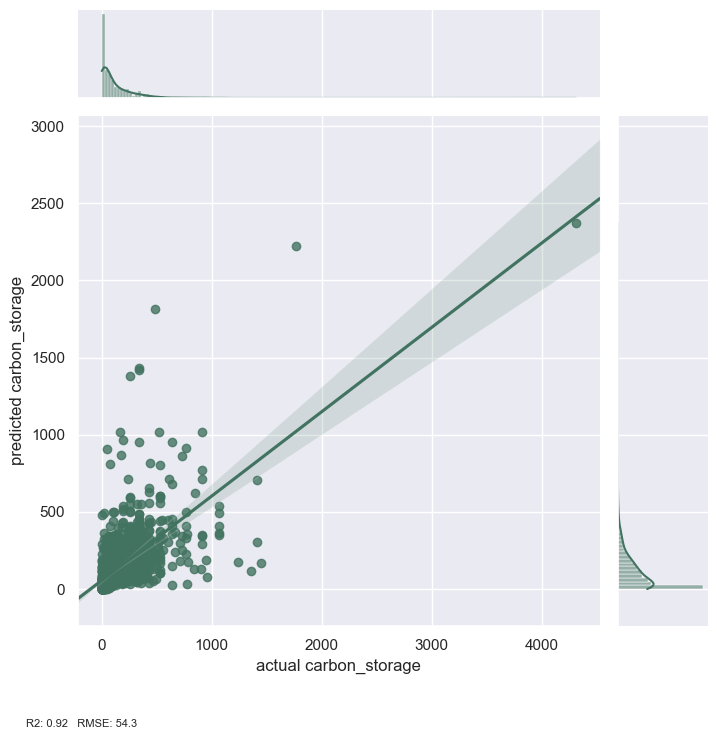

Model: carbon_seq


,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,...,selje,sitkagran,spisslønn,svensk asal,syrin,sølvasal,sølvpil,tartarlønn,ullungrogn,valnøtt
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,21.652,2.246,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,11.646,1.721,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,NaN,b_180401_6158,3.38,16.50,1,Selje,16.379,2.003,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,149.009,7.579,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
4,NaN,b_180401_6160,2.85,49.99,1,Selje,29.282,2.293,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

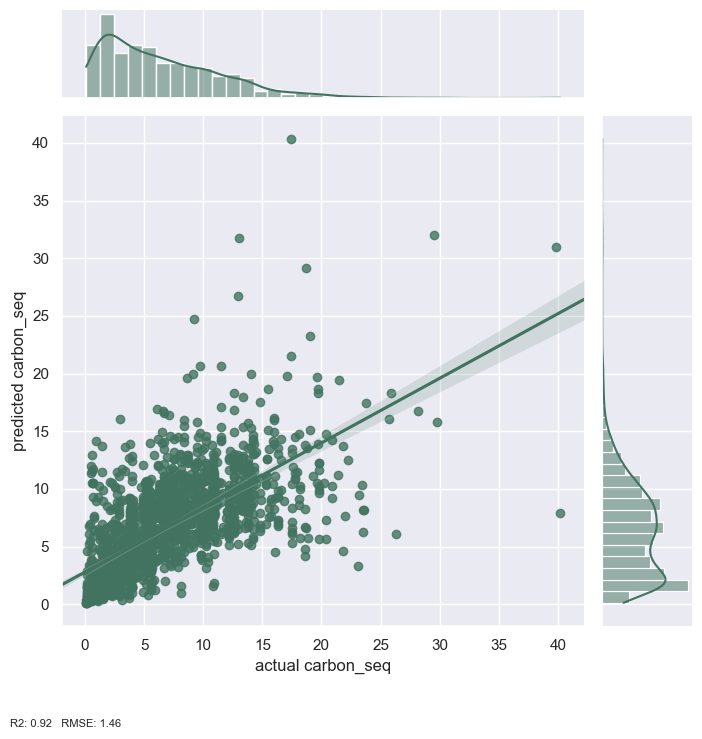

Model: runoff


,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,...,selje,sitkagran,spisslønn,svensk asal,syrin,sølvasal,sølvpil,tartarlønn,ullungrogn,valnøtt
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,21.652,2.246,0.000,NaN,...,0,0,0,0,0,0,0,0,0,0
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,11.646,1.721,0.000,NaN,...,0,0,0,0,0,0,0,0,0,0
2,NaN,b_180401_6158,3.38,16.50,1,Selje,16.379,2.003,0.000,NaN,...,1,0,0,0,0,0,0,0,0,0
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,149.009,7.579,0.047,NaN,...,0,0,0,1,0,0,0,0,0,0
4,NaN,b_180401_6160,2.85,49.99,1,Selje,29.282,2.293,0.000,NaN,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

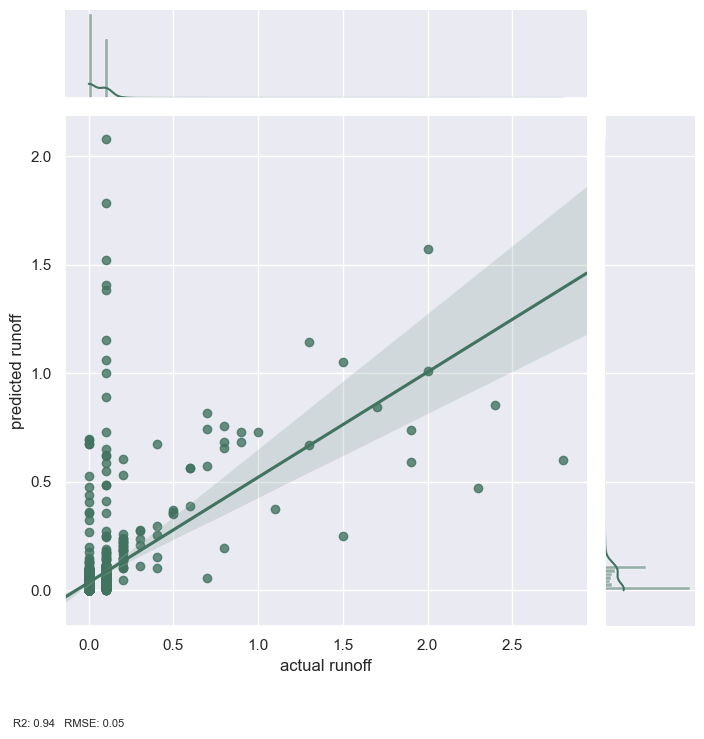

Model: total_pollution


,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,...,selje,sitkagran,spisslønn,svensk asal,syrin,sølvasal,sølvpil,tartarlønn,ullungrogn,valnøtt
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,21.652,2.246,0.000,4.941,...,0,0,0,0,0,0,0,0,0,0
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,11.646,1.721,0.000,15.323,...,0,0,0,0,0,0,0,0,0,0
2,NaN,b_180401_6158,3.38,16.50,1,Selje,16.379,2.003,0.000,6.347,...,1,0,0,0,0,0,0,0,0,0
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,149.009,7.579,0.047,38.741,...,0,0,0,1,0,0,0,0,0,0
4,NaN,b_180401_6160,2.85,49.99,1,Selje,29.282,2.293,0.000,20.120,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

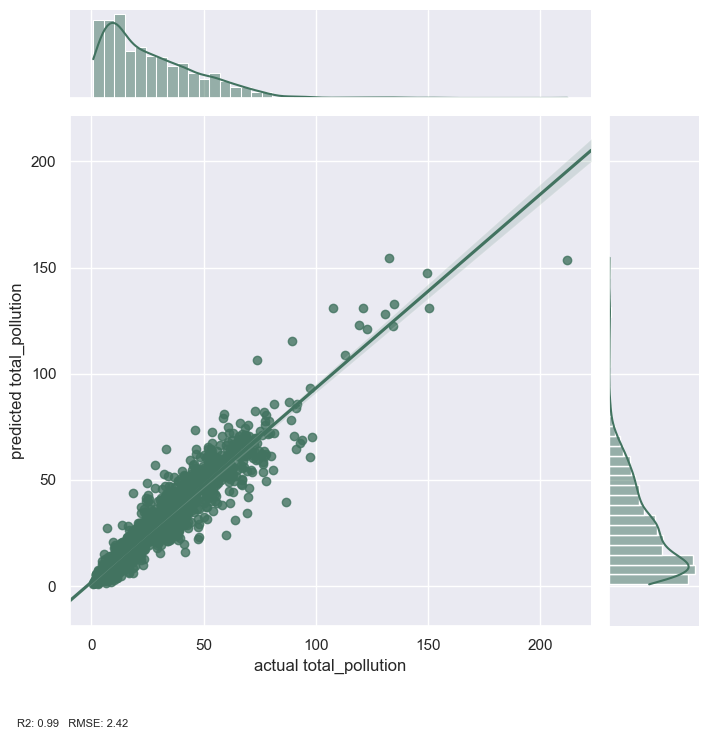

Model: totben_cap


,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,...,selje,sitkagran,spisslønn,svensk asal,syrin,sølvasal,sølvpil,tartarlønn,ullungrogn,valnøtt
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,21.652,2.246,0.000,4.941,...,0,0,0,0,0,0,0,0,0,0
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,11.646,1.721,0.000,15.323,...,0,0,0,0,0,0,0,0,0,0
2,NaN,b_180401_6158,3.38,16.50,1,Selje,16.379,2.003,0.000,6.347,...,1,0,0,0,0,0,0,0,0,0
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,149.009,7.579,0.047,38.741,...,0,0,0,1,0,0,0,0,0,0
4,NaN,b_180401_6160,2.85,49.99,1,Selje,29.282,2.293,0.000,20.120,...,1,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

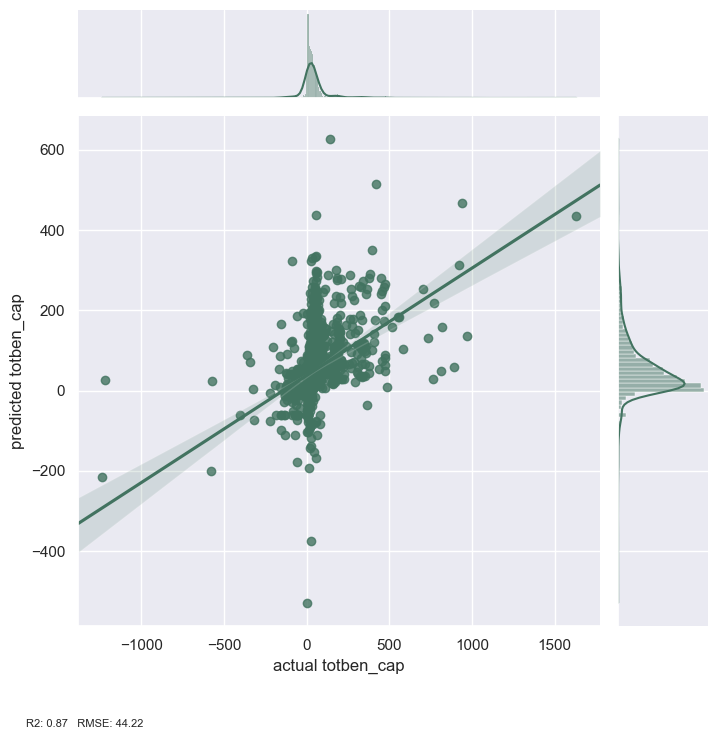

In [25]:
from sklearn.ensemble import RandomForestRegressor

X = df[predictors]
X_target = df_target[predictors]
seed = 42
test_size = 0.3

dict_results = {}

for var in response_vars:
    y = df[var]

    # SPLIT DATA
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )

    # TRAIN MODEL
    # Create and fit the Random Forest model
    model = RandomForestRegressor(random_state=seed)
    model.fit(X_train, y_train)

    # Make predictions on the training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # EVALUATE MODEL
    # store model results in dataframe df_results
    r2_train = round(r2_score(y_train, y_train_pred), 2)
    r2_test = round(r2_score(y_test, y_test_pred), 2)
    rmse_train = round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)

    df_results = pd.DataFrame(
        columns=[
            "model_name",
            "response_var",
            "train_rmse",
            "test_rmse",
            "train_r2",
            "test_r2",
        ]
    )
    df_results["model_name"] = f"model_{var}"
    df_results["response_var"] = var
    df_results["train_rmse"] = rmse_train
    df_results["test_rmse"] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    df_results["train_r2"] = r2_train
    df_results["test_r2"] = r2_test

    # append results dataframe to dict
    dict_results[f"model_{var}"] = df_results

    # DEPLOY MODEL
    # Apply the Random Forest model to the df_target dataset
    y_target_pred = model.predict(X_target)

    # Fill the response columns in df_target with the predicted values
    df_target[var] = y_target_pred

    # DISPLAY RESULTS
    print(f"Model: {var}")
    display(df_target.head())

    # plot results and save plot to output folder
    plt.clf()  # clear figure

    # Regression plot
    sns.jointplot(
        x=y_test,
        y=y_test_pred,
        kind="reg",
        truncate=False,
        # xlim=(0, 60), ylim=(0, 12),
        color="#427360",
        height=7,
    )
    plt.xlabel(f"actual {var}")
    plt.ylabel(f"predicted {var}")
    plt.figtext(
        0,
        -0.05,
        f"R2: {r2_train}   RMSE: {rmse_train}",
        ha="left",
        fontsize=8,
    )
    plt.show()

In [26]:
# Print Evaluation for RF 
df_results = pd.concat(dict_results.values(), ignore_index=True)
display(df_results.head())

,model_name,response_var,train_rmse,test_rmse,train_r2,test_r2


### Export Results

In [27]:
display(df_target.head())

# round values
df_target[predictors + response_vars] = round(df_target[predictors + response_vars], 3)

# drop species cols
drop_cols = target_species_encoded.columns


df_target.drop(drop_cols, axis=1, inplace=True)
display(df_target.head())

,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,...,selje,sitkagran,spisslønn,svensk asal,syrin,sølvasal,sølvpil,tartarlønn,ullungrogn,valnøtt
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,21.652,2.246,0.000,4.941,...,0,0,0,0,0,0,0,0,0,0
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,11.646,1.721,0.000,15.323,...,0,0,0,0,0,0,0,0,0,0
2,NaN,b_180401_6158,3.38,16.50,1,Selje,16.379,2.003,0.000,6.347,...,1,0,0,0,0,0,0,0,0,0
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,149.009,7.579,0.047,38.741,...,0,0,0,1,0,0,0,0,0,0
4,NaN,b_180401_6160,2.85,49.99,1,Selje,29.282,2.293,0.000,20.120,...,1,0,0,0,0,0,0,0,0,0


,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,totben_cap,lon_x,lat_y
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,21.652,2.246,0.000,4.941,4.244,14.405960,67.290894
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,11.646,1.721,0.000,15.323,6.936,14.404625,67.289885
2,NaN,b_180401_6158,3.38,16.50,1,Selje,16.379,2.003,0.000,6.347,6.398,14.406264,67.289688
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,149.009,7.579,0.047,38.741,31.041,14.404566,67.289721
4,NaN,b_180401_6160,2.85,49.99,1,Selje,29.282,2.293,0.000,20.120,24.798,14.404638,67.289630


In [28]:
# set values < 0 to 0 
col_names = ['carbon_storage', 'carbon_seq', 'runoff', 'total_pollution', 'totben_cap']

#for col_name in col_names:
    #df_target[col_name] = df_target[col_name].where(df_target[col_name] <= 0, 0)

display(df_target.head())

,tree_id,crown_id,tree_height,crown_area,pollution_zone,species,carbon_storage,carbon_seq,runoff,total_pollution,totben_cap,lon_x,lat_y
0,NaN,b_180401_6156,2.78,13.00,1,Bjørk,21.652,2.246,0.000,4.941,4.244,14.405960,67.290894
1,NaN,b_180401_6157,2.70,46.24,1,Rogn,11.646,1.721,0.000,15.323,6.936,14.404625,67.289885
2,NaN,b_180401_6158,3.38,16.50,1,Selje,16.379,2.003,0.000,6.347,6.398,14.406264,67.289688
3,NaN,b_180401_6159,3.06,120.47,1,Svensk asal,149.009,7.579,0.047,38.741,31.041,14.404566,67.289721
4,NaN,b_180401_6160,2.85,49.99,1,Selje,29.282,2.293,0.000,20.120,24.798,14.404638,67.289630


In [29]:
# export the results in df_target
df_target.to_csv(output_extrapolation, index=False, sep=",")
df_results.to_csv(output_extrapolation.replace(".csv", "_results.csv"), index=False, sep=",")

Linear Regression (old)

In [ ]:
X = df[predictors]
X_target = df_target[predictors]
seed = 42
test_size = 0.3

dict_results = {}

# TODO store model in dictionairy {model_name:model}
# TODO store model results in dataframe df_results dict. {model_name:df_results}

# loop over response variables and calc. linear regression
for var in response_vars:
    y = df[var]

    # SPLIT DATA
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )

    # TRAIN MODEL
    # Create and fit the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    b0 = round(model.intercept_, 1)
    b1 = round(model.coef_[0], 1)
    b2 = round(model.coef_[1], 1)
    b3 = round(model.coef_[2], 1)
    b4 = round(model.coef_[3], 1)
    y = var
    x1 = predictors[0]
    x2 = predictors[1]
    x3 = predictors[2]
    x4 = predictors[3]

    model_equation = f"y = {b0} + {b1}*{x1} + {b2}*{x2} + {b3}*{x3} + {b4}*{x4} + ..."

    # Make predictions on the training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # EVALUATE MODEL
    # store model results in dataframe df_results
    r2_train = round(r2_score(y_train, y_train_pred), 2)
    r2_test = round(r2_score(y_test, y_test_pred), 2)
    r2_train = round(r2_train, 2)
    rmse_train = round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)

    df_results = pd.DataFrame(
        columns=[
            "model_name",
            "response_var",
            "equation",
            "train_rmse",
            "test_rmse",
            "train_r2",
            "test_r2",
        ]
    )
    df_results["model_name"] = f"model_{var}"
    df_results["response_var"] = var
    df_results["equation"] = model_equation
    df_results["train_rmse"] = rmse_train
    df_results["test_rmse"] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    df_results["train_r2"] = r2_train
    df_results["test_r2"] = r2_test

    # append results dataframe to dict
    dict_results[f"model_{var}"] = df_results

    # DEPLOY MODEL
    # Apply the regression model to the df_target dataset
    y_target_pred = model.predict(X_target)

    # Fill the response columns in df_target with the predicted values
    df_target[var] = y_target_pred

    # DISPLAY RESULTS
    print(f"Model: {var}")
    print(f"Equation: {model_equation}")
    display(df_target.head())

    # plot results and save plot to output folder
    plt.clf()  # clear figure

    # Regression plot
    sns.jointplot(
        x=y_test,
        y=y_test_pred,
        kind="reg",
        truncate=False,
        # xlim=(0, 60), ylim=(0, 12),
        color="#427360",
        height=7,
    )
    plt.xlabel(f"actual {var}")
    plt.ylabel(f"predicted {var}")
    plt.figtext(
        0,
        -0.05,
        f"R2: {r2_train}   RMSE: {rmse_train}\n {model_equation}",
        ha="left",
        fontsize=8,
    )
    plt.show()

    # save plot to output folder
    # output_path = os.path.join(INTERIM_PATH, f'linear_reg_{var}.png')
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')